In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet
from lib.sampling import get_slides
from SlideRunner.dataAccess.annotations import AnnotationType
size=512
path = Path('./')

database = Database()
database.open(str(path/'./TUPAC_alternativeLabels_augmented.sqlite'))

import random
random.seed(42)
slides = [x[0] for x in database.execute('SELECT uid from Slides').fetchall()]


import pickle
sets = pickle.load(open('TUPAC_Trainingset_Folds.p','rb'))


fold = 0
slidelist_test = [(1+sets['test'][fold]).tolist()][0]+np.arange(74,108).tolist()
slidelist_trainval = 1+sets['training'][fold]
slidelist_val = random.sample(slidelist_trainval.tolist(),10)


In [2]:
np.sort(slidelist_test).tolist(), np.sort(slidelist_val)

([5,
  6,
  13,
  17,
  19,
  21,
  23,
  25,
  26,
  29,
  30,
  32,
  34,
  36,
  38,
  41,
  43,
  48,
  49,
  51,
  52,
  59,
  60,
  64,
  69,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107],
 array([ 2,  8,  9, 10, 14, 15, 22, 31, 39, 70]))

In [3]:
np.max(slidelist_trainval)

73

In [4]:
sorted(slidelist_trainval.tolist())

[1,
 2,
 3,
 4,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 18,
 20,
 22,
 24,
 27,
 28,
 31,
 33,
 35,
 37,
 39,
 40,
 42,
 44,
 45,
 46,
 47,
 50,
 53,
 54,
 55,
 56,
 57,
 58,
 61,
 62,
 63,
 65,
 66,
 67,
 68,
 70,
 71,
 72,
 73]

## Split dataset into train/validation and test on slide level

Convert database into in-memory object

In [5]:
def sampling_func(y, **kwargs):
    y_label = np.array(y[1])
    h, w = kwargs['size']

    _arbitrary_prob = 0.1
    _mit_prob = 0.9
    
    sample_prob = np.array([_arbitrary_prob,  _mit_prob])
    
    case = np.random.choice(2, p=sample_prob)
    
    
    
    bg_label = [0] if y_label.dtype == np.int64 else ["bg"]
    classes = bg_label + kwargs['classes']
    level_dimensions = kwargs['level_dimensions']
    level = kwargs['level']
    if ('bg_label_prob' in kwargs):
        _bg_label_prob = kwargs['bg_label_prob']
        if (_bg_label_prob>1.0):
            raise ValueError('Probability needs to be <= 1.0.')
    else:
        _bg_label_prob = 0.0  # add a backgound label to sample complete random
    
    if ('strategy' in kwargs):
        _strategy = kwargs['strategy']
    else:
        _strategy = 'normal'
        
    if ('set' in kwargs):
        _set = kwargs['set']
    else:
        _set = 'training'

        
    _random_offset_scale = 0.5  # up to 50% offset to left and right of frame
    xoffset = randint(-w, w) * _random_offset_scale
    yoffset = randint(-h, h) * _random_offset_scale
    coords = np.array(y[0])

    slide_width, slide_height = level_dimensions[level]
    
    if (case==0):
        xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), slide_height - h)
    if (case==1): # mitosis
        
        ids = y_label == 1

        if (_set == 'training'):
            ids[coords[:,1]>slide_height/2] = 0 # lower part not allowed
        elif (_set == 'validation'):
            ids[coords[:,1]<slide_height/2] = 0 # upper part not allowed

        if (np.count_nonzero(ids)<1):
            xmin, ymin = randint(int(w / 2 - xoffset), slide_width - w), randint(int(h / 2 - yoffset), slide_height - h)
        else:
            xmin, ymin, xmax, ymax = np.array(y[0])[ids][randint(0, np.count_nonzero(ids) - 1)]

    return int(xmin - w / 2 + xoffset), int(ymin - h / 2 +yoffset)


def get_slides(slidelist_test:list, database:"Database", positive_class:int=1, negative_class:int=7, basepath:str='WSI', slidelist_val:list=[], size:int=256):


    lbl_bbox=list()
    files=list()
    train_slides=list()
    val_slides=list()

    getslides = """SELECT uid, directory,filename FROM Slides"""
    for idx, (currslide, direct, filename) in enumerate(tqdm(database.execute(getslides).fetchall(), desc='Loading slides .. ')):
        if (str(currslide) in slidelist_test): # skip test slides
            continue

        database.loadIntoMemory(currslide)

        slide_path = basepath + os.sep + filename

        slide = openslide.open_slide(str(slide_path))

        level = 0#slide.level_count - 1
        level_dimension = slide.level_dimensions[level]
        down_factor = slide.level_downsamples[level]

        classes = {positive_class: 1} # Map non-mitosis to background

        labels, bboxes = [], []
        annotations = dict()
        for id, annotation in database.annotations.items():
            if annotation.deleted or annotation.annotationType != AnnotationType.SPOT:
                continue
            annotation.r = 25
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            if annotation.agreedClass not in annotations:
                annotations[annotation.agreedClass] = dict()
                annotations[annotation.agreedClass]['bboxes'] = list()
                annotations[annotation.agreedClass]['label'] = list()

            annotations[annotation.agreedClass]['bboxes'].append([int(x_min), int(y_min), int(x_max), int(y_max)])
            annotations[annotation.agreedClass]['label'].append(annotation.agreedClass)

            if annotation.agreedClass in classes:
                label = classes[annotation.agreedClass]

                bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
                labels.append(label)

        if len(bboxes) > 0:
            if (len(slidelist_val)==0):
                lbl_bbox.append([bboxes, labels])
                files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='training', negative_class=negative_class)))
                train_slides.append(len(files)-1)

                lbl_bbox.append([bboxes, labels])
                files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='validation', negative_class=negative_class)))
                val_slides.append(len(files)-1)
            else:
                if (currslide not in slidelist_val):
                    lbl_bbox.append([bboxes, labels])
                    files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='training', negative_class=negative_class)))
                    train_slides.append(len(files)-1)
                else:
                    lbl_bbox.append([bboxes, labels])
                    files.append(SlideContainer(file=slide_path, annotations=annotations, level=level, width=size, height=size, y=[bboxes, labels], sample_func=partial(sampling_func, set='validation', negative_class=negative_class)))
                    val_slides.append(len(files)-1)

    return lbl_bbox, train_slides,val_slides,files


In [6]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, slidelist_val=slidelist_val, negative_class=2, positive_class=1,  
                                                     size=size,database=database,basepath='./TUPACstitched/')

Loading slides .. : 100%|██████████| 107/107 [00:01<00:00, 77.09it/s]


In [7]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [8]:
slidelist_val

[39, 10, 14, 15, 2, 9, 8, 31, 22, 70]

In [9]:
bs = 12
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))


In [10]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.2,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.2,
                      #xtra_tfms=xtra_tfms,
                     )


In [11]:
path

PosixPath('.')

In [12]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min, num_workers=4).normalize()

In [13]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.04438653371323109, 'col_pct': 0.4360575154549723, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 6}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-90, 90)}, p=0.5, resolved={'degrees': 51.557072076662735}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.2), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.5, resolved={'scale': 1.1968471698633179, 'row_pct': 0.11564578402933046, 'col_pct': 0.8995047329111996}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=

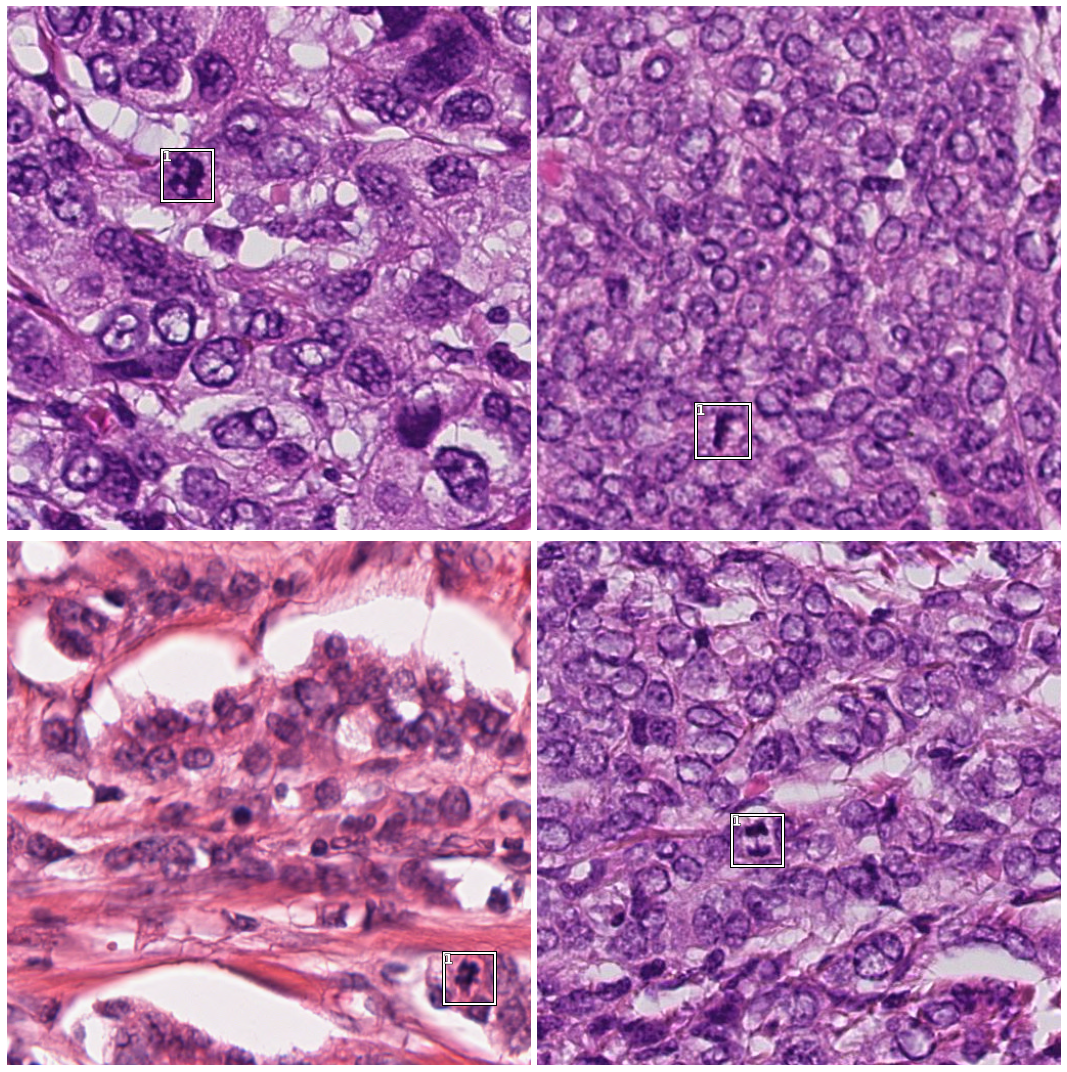

In [14]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(15,15))

In [15]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7,0.8,0.9])


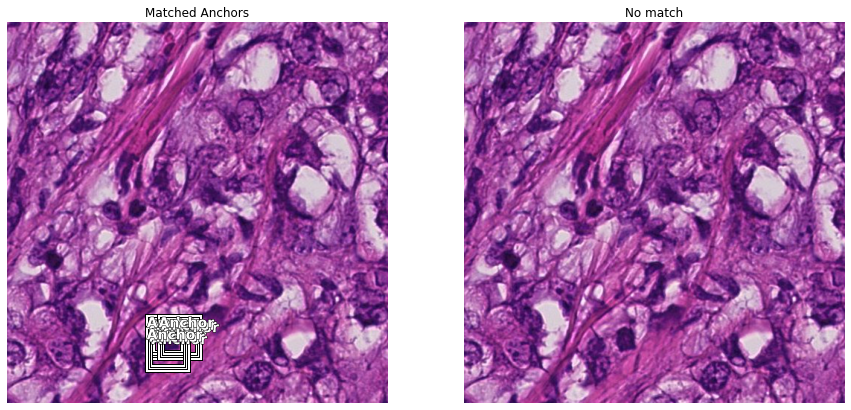

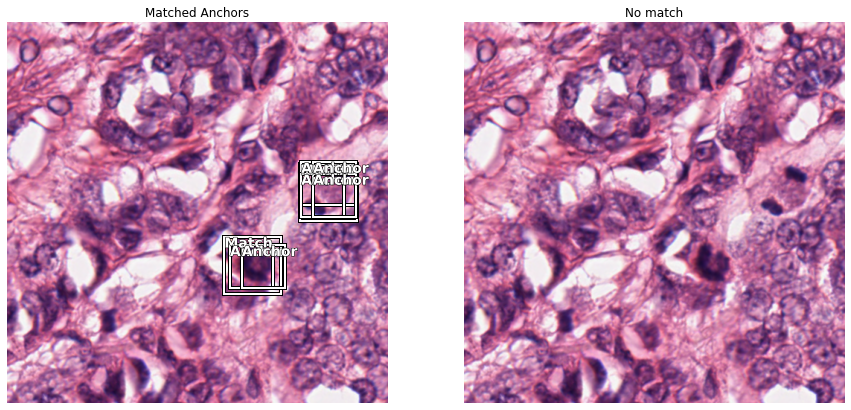

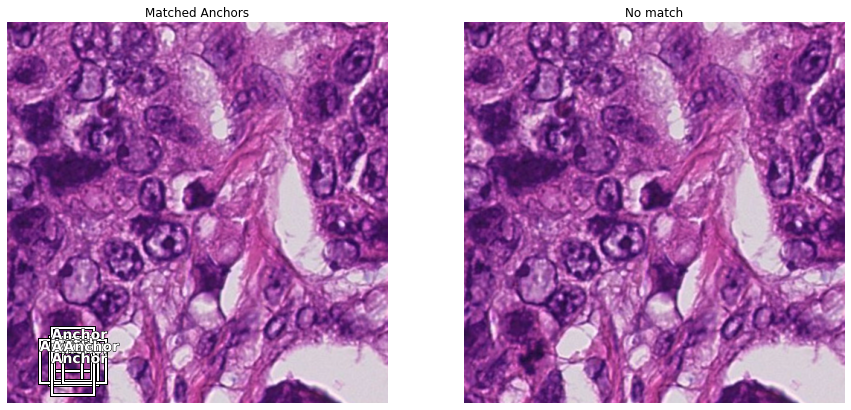

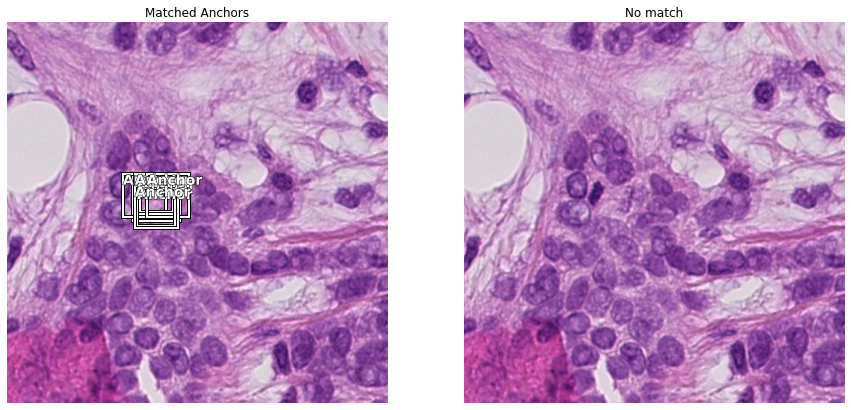

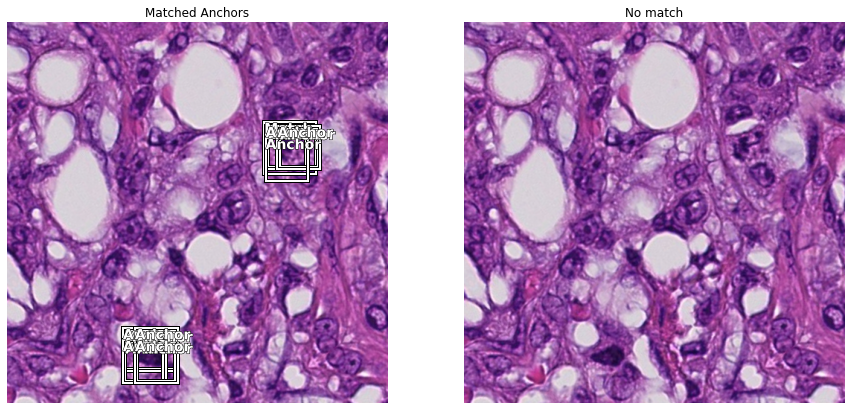

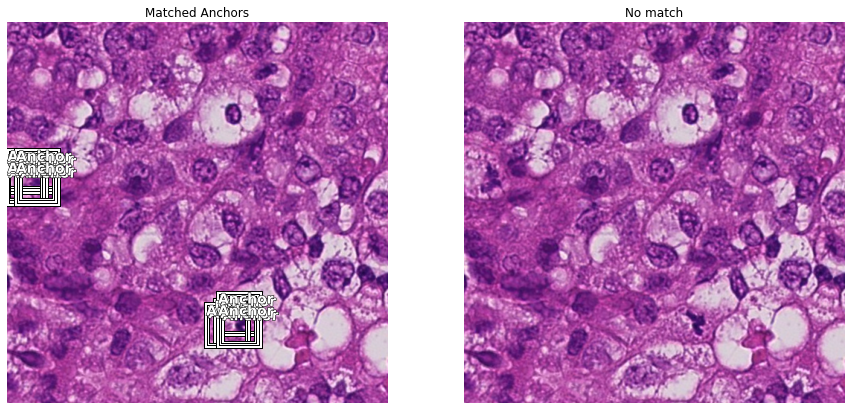

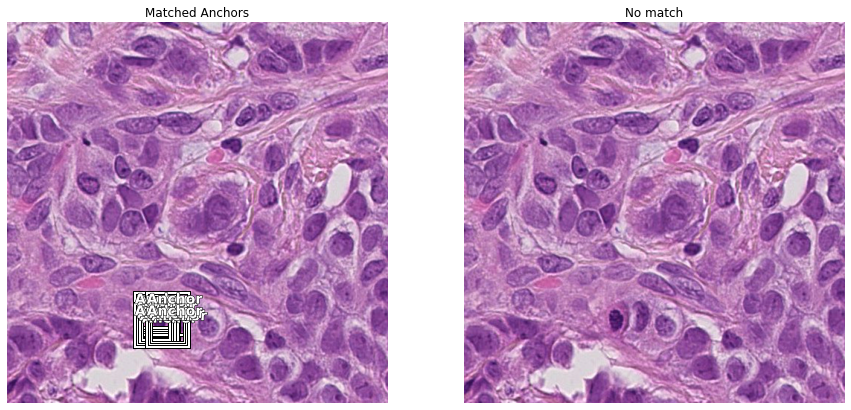

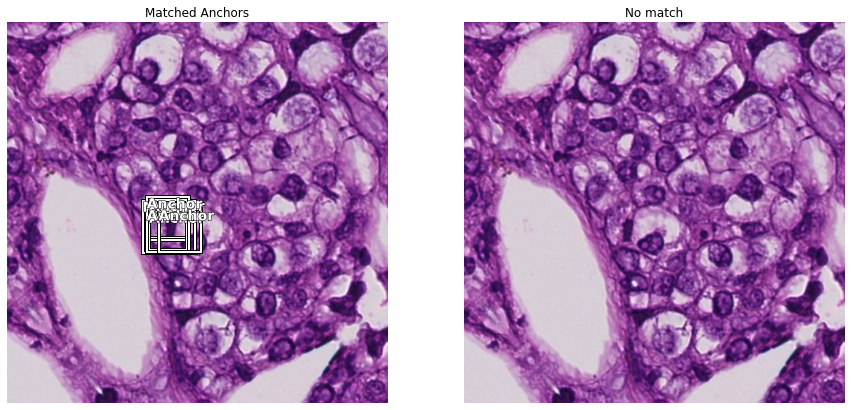

In [16]:
not_found = show_anchors_on_images(data, anchors)

In [17]:
crit = RetinaNetFocalLoss(anchors)

In [18]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=4, sizes=[32], chs=128, final_bias=-4., n_conv=3)



In [19]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [20]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


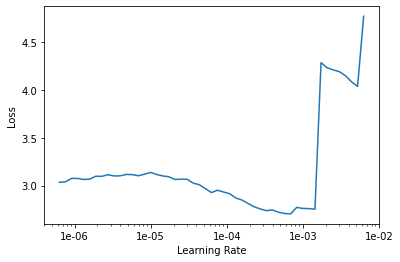

In [21]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 3442/3442 [00:01<00:00, 3039.63it/s]


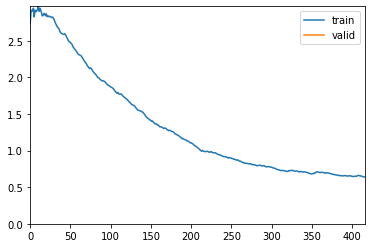

In [22]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 3370/3370 [00:01<00:00, 3181.99it/s]


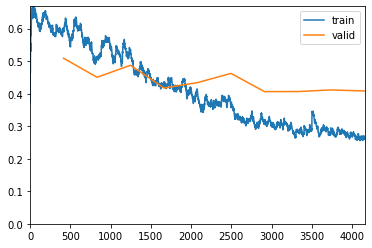

GT: 100%|██████████| 3344/3344 [00:01<00:00, 3317.53it/s]


In [23]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|██████████| 3276/3276 [00:00<00:00, 3465.81it/s]


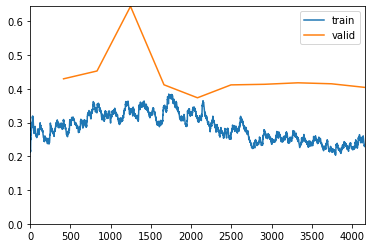

GT: 100%|██████████| 3331/3331 [00:00<00:00, 3490.44it/s]


In [24]:
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

GT: 100%|██████████| 3524/3524 [00:01<00:00, 3252.60it/s]


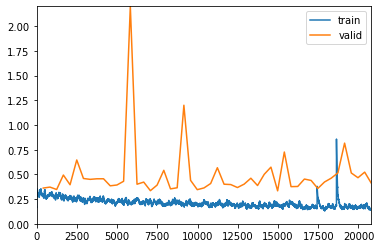

Better model found at epoch 0 with pascal_voc_metric value: 0.5649994117413619.


GT: 100%|██████████| 3323/3323 [00:00<00:00, 3607.25it/s]


Better model found at epoch 3 with pascal_voc_metric value: 0.5859786506822365.


GT: 100%|██████████| 3260/3260 [00:00<00:00, 3666.89it/s]


Better model found at epoch 5 with pascal_voc_metric value: 0.6318662050558648.


GT: 100%|██████████| 2435/2435 [00:00<00:00, 5118.19it/s]


Better model found at epoch 13 with pascal_voc_metric value: 0.763762404962269.


GT: 100%|██████████| 3341/3341 [00:00<00:00, 3365.41it/s]


In [25]:
learn.unfreeze()
lr=1e-4

learn.fit(50, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

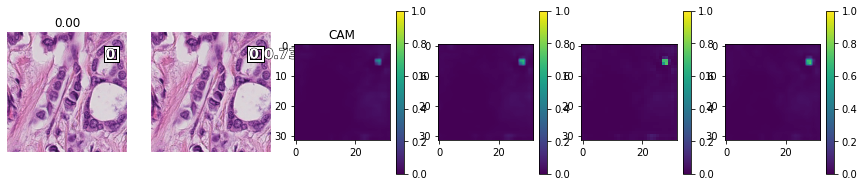

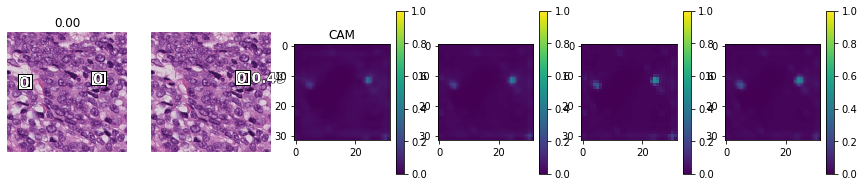

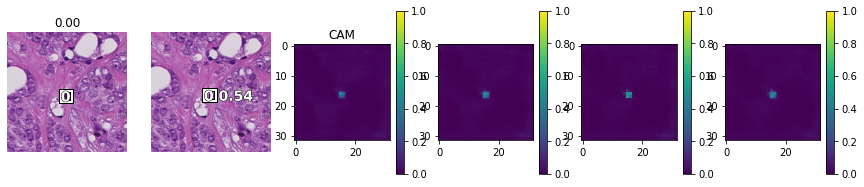

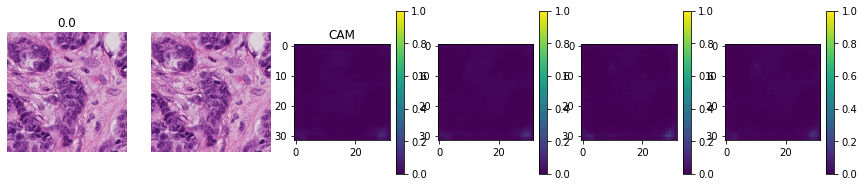

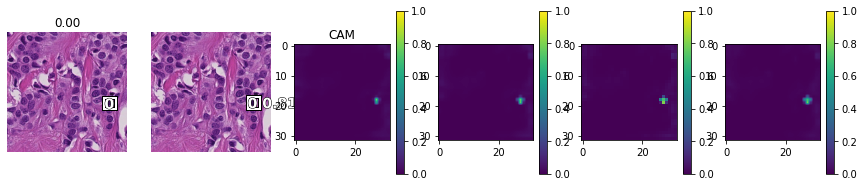

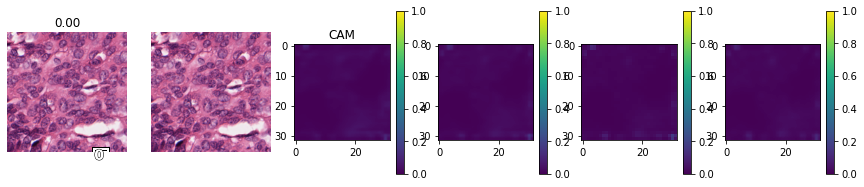

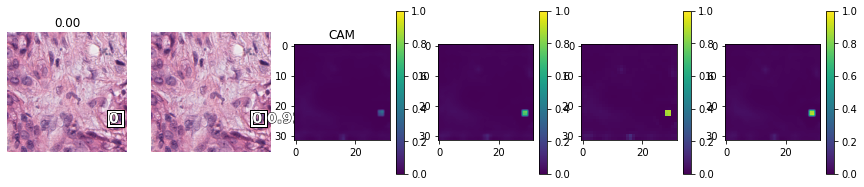

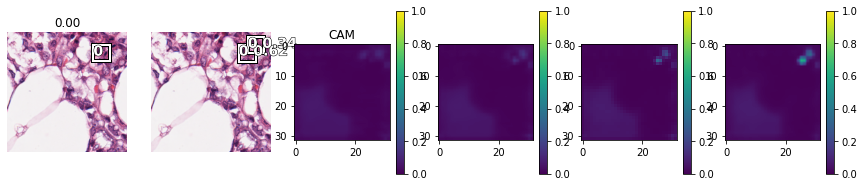

In [26]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [27]:
#learn.save('RetinaNet-TUPAC_AL-OrigSplit-512s', with_opt=True)
learn.export("RetinaNet-TUPAC_AL-CrossValidationTrainingset-Batch1-512s.pth")

In [28]:
#torch.save(learn.model.state_dict(), "RetinaNet-TUPAC_CB-512s-OrigSplit_statedict.pth")

In [29]:
learn.data.stats

[tensor([0.5994, 0.3672, 0.6172]), tensor([0.2189, 0.2096, 0.1961])]

In [30]:
slidelist_test

[41,
 36,
 48,
 51,
 38,
 13,
 69,
 17,
 59,
 64,
 29,
 43,
 30,
 49,
 6,
 21,
 52,
 19,
 60,
 25,
 23,
 34,
 32,
 26,
 5,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107]

In [31]:
pickle.dump(slidelist_test,open('slidelist_test_TUPAC_AL__CrossValidataion_batch1.p','wb'))

In [32]:
slidelist_trainval

array([42, 14, 27, 50, 66, 70, 31, 10,  8, 16, 37,  1, 68, 53,  9,  2, 73, 15, 67, 40, 28, 54, 24, 33, 58, 65, 11, 61,
       12, 72, 35, 62, 56, 47, 22, 57, 45, 20, 55,  3, 39,  7, 44, 46,  4, 71, 63, 18])